# Data Partitioning

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import random

def processData(name,testing_size):
    path = 'data/' + name + ".mat" 
    data = scipy.io.loadmat(path)

    data_X = data["training_data"]
    data_y = data["training_labels"]
    data_t = data["test_data"]
    
    if testing_size <= 1:
        testing_size = int(testing_size * data_X.shape[0])
    
    # random.seed(189)
    index = random.sample(range(data_X.shape[0]),data_X.shape[0]-testing_size)

    data_X_train = data_X[index]
    data_X_validate = np.delete(data_X, index, axis=0)
    data_y_train = data_y[index]
    data_y_validate = np.delete(data_y, index, axis=0)

    Data = dict()
    Data["X_train"] = data_X_train
    Data["X_validate"] = data_X_validate
    Data["y_train"] = data_y_train
    Data["y_validate"] = data_y_validate
    Data["test"] = data_t
    return Data
    


In [2]:
mnistData = processData("mnist_data",10000)

In [3]:
spamData = processData("spam_data",0.2)
print(spamData["X_train"].shape)

(4138, 32)


In [4]:
cifar10Data = processData("cifar10_data",5000)
print(cifar10Data["X_train"].shape)

(45000, 3072)


In [5]:
from sklearn import svm
from sklearn.metrics import accuracy_score

def svmFit(data,training_sample,c=1,kernel="linear",gam="scale"):
    data_X = data["X_train"]
    data_y = data["y_train"]
    
    # random.seed(189)
    index = random.sample(range(data_X.shape[0]),training_sample)

    data_X_train = data_X[index]
    data_X_validate = data["X_validate"]
    data_y_train = data_y[index]
    data_y_validate = data["y_validate"]

    classifier=svm.SVC(C=c,kernel=kernel,max_iter=-1,gamma=gam)
    classifier.fit(data_X_train,data_y_train.ravel())
    
    y_validate = classifier.predict(data_X_validate)
    validate_accuracy = accuracy_score(y_validate,data_y_validate)
    
    y_train = classifier.predict(data_X_train)
    train_accuracy = accuracy_score(y_train,data_y_train)
    return train_accuracy,validate_accuracy

# Support Vector Machines: Coding
Fit the model using given number of training sample and predict on the validation set.

In [9]:
# mnistData
t_error = []
v_error = []
training_sample = [100, 200, 500, 1000, 2000, 5000, 10000]
for i in training_sample:
    ta,va = svmFit(mnistData,i,c=1)
    print(ta,va)
    t_error.append(1-ta)
    v_error.append(1-va)


1.0 0.7423
1.0 0.8088
1.0 0.8698
1.0 0.8746
1.0 0.8965
1.0 0.901
1.0 0.9101


In [10]:
# Optional: Fit the model by polynomial kernel
svmFit(mnistData,10000,c=2,kernel="poly")[1]

0.957

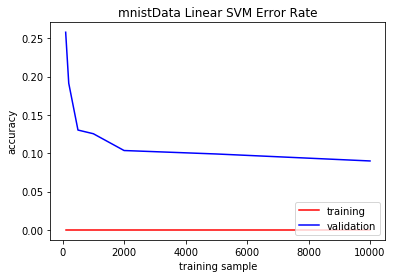

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_sample,t_error,c="red",label="training")
plt.plot(training_sample,v_error,c="blue",label="validation")
plt.legend(loc="lower right")
plt.xlabel("training sample")
plt.ylabel("accuracy")
plt.title("mnistData Linear SVM Error Rate")

plt.show()

In [12]:
# spamData
t_error = []
v_error = []

training_sample = [100, 200, 500, 1000, 2000,4138]
for i in training_sample:
    ta,va = svmFit(spamData,i,c=1,kernel="linear",gam="scale")
    print(ta,va)
    t_error.append(1-ta)
    v_error.append(1-va)

0.84 0.753384912959381
0.85 0.8133462282398453
0.856 0.8143133462282398
0.793 0.8007736943907157
0.7925 0.809477756286267
0.7996616723054616 0.8123791102514507


In [13]:
# Optional: Fit the model by kernel
svmFit(spamData,4138 ,c=20,kernel="rbf",gam="scale")[1]

0.8355899419729207

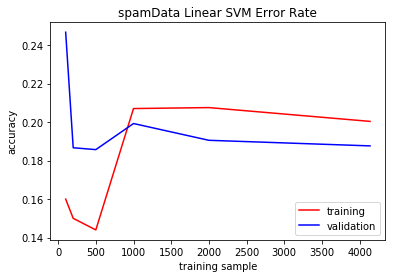

In [14]:
plt.plot(training_sample,t_error,c="red",label="training")
plt.plot(training_sample,v_error,c="blue",label="validation")
plt.legend(loc="lower right")
plt.xlabel("training sample")
plt.ylabel("accuracy")
plt.title("spamData Linear SVM Error Rate")

plt.show()

In [15]:
# cifar10Data
t_error = []
v_error = []

training_sample = [100, 200, 500, 1000, 2000, 5000]
for i in training_sample:
    ta,va = svmFit(cifar10Data,i,c=1,kernel="linear")
    print(ta,va)
    t_error.append(1-ta)
    v_error.append(1-va)


1.0 0.2154
1.0 0.2504
1.0 0.2714
1.0 0.2738
1.0 0.291
1.0 0.303


In [16]:
# Optional: Fit the model by kernel
svmFit(cifar10Data,5000,c=0.1,kernel="poly")[1]

0.3778

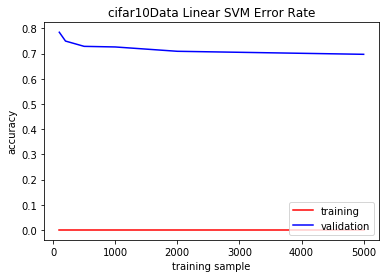

In [17]:
plt.plot(training_sample,t_error,c="red",label="training")
plt.plot(training_sample,v_error,c="blue",label="validation")
plt.legend(loc="lower right")
plt.xlabel("training sample")
plt.ylabel("accuracy")
plt.title("cifar10Data Linear SVM Error Rate")

plt.show()

# Hyperparameter Tuning

In [38]:
v_accuracy = []

listC = [x/10 for x in range(1,10)] + list(range(1,6))
for i in listC:
    va = svmFit(mnistData,10000,c=i)[1]
    print(i,va)
    v_accuracy.append(va)

0.1 0.9124
0.2 0.9087
0.3 0.9075
0.4 0.9104
0.5 0.9119
0.6 0.9157
0.7 0.9149
0.8 0.9108
0.9 0.9167
1 0.9103
2 0.9113
3 0.9139
4 0.9092
5 0.9124


# K-Fold Cross-Validation

In [39]:
def KFoldCV(name,c,k=5,kernel="linear"):
    path = 'data/' + name + ".mat" 
    data = scipy.io.loadmat(path)
    
    data_X = data["training_data"]
    data_y = data["training_labels"]
    
    random.seed(189)
    index = random.sample(range(data_X.shape[0]),data_X.shape[0])
    data_X = data_X[index]   
    data_y = data_y[index]
    
    accu = []
    for i in range(k):
        index = list(range( int(data_X.shape[0]*i/k) , int(data_X.shape[0]*(i+1)/k)))
        data_X_validate = data_X[index]
        data_X_train = np.delete(data_X, index, axis=0)
        data_y_validate = data_y[index]
        data_y_train = np.delete(data_y, index, axis=0)
               
        classifier=svm.SVC(C=c,kernel=kernel,max_iter=-1,gamma="scale")
        classifier.fit(data_X_train,data_y_train.ravel())

        y_validate = classifier.predict(data_X_validate)
        validate_accuracy = accuracy_score(y_validate,data_y_validate)
        accu.append(validate_accuracy)
    
    return sum(accu)/len(accu)

In [40]:
kfold_accuracy = []

listC = [x/10 for x in range(1,10)] + list(range(1,6))
for i in listC:
    ka = KFoldCV('spam_data',c=i,kernel="linear")
    print(i,ka)
    kfold_accuracy.append(ka)

0.1 0.7938898700230801
0.2 0.7967906633401546
0.3 0.799304235696465
0.4 0.799304235696465
0.5 0.8002709799194536
0.6 0.8006574533494053
0.7 0.8004642166344296
0.8 0.8008510638297872
0.9 0.8014309608574178
1 0.8012377241424421
2 0.8016243844550968
3 0.8020110447677515
4 0.8020112316504546
5 0.8022046552481334


# Prediction on the test data

In [19]:
# mnistData
name = "mnist_data"
path = 'data/' + name + ".mat" 
data = scipy.io.loadmat(path)

data_X_train = data["training_data"]
data_y_train = data["training_labels"]
data_X_test = data["test_data"]

# # random.seed(189)
# index = random.sample(range(data_X_train.shape[0]),50000)

# data_X_train = data_X_train[index]
# data_y_train = data_y_train[index]

classifier=svm.SVC(C=1,kernel="poly",max_iter=-1,gamma='scale')
classifier.fit(data_X_train,data_y_train.ravel())

y_test = classifier.predict(data_X_test)

In [20]:
print(y_test)
save = pd.DataFrame(y_test)
save.index = range(1,len(save) + 1)
save.to_csv("mnist_predict.csv")

[7 2 1 ... 4 5 6]


In [15]:
# spamData
name = "spam_data"
path = 'data/' + name + ".mat" 
data = scipy.io.loadmat(path)

data_X_train = data["training_data"]
data_y_train = data["training_labels"]
data_X_test = data["test_data"]

classifier=svm.SVC(C=1,kernel="poly",max_iter=-1,gamma="scale")
classifier.fit(data_X_train,data_y_train.ravel())

y_test = classifier.predict(data_X_test)

In [16]:
print(y_test)
save = pd.DataFrame(y_test)
save.index = range(1,len(save) + 1)
save.to_csv("spam_predict.csv")

[0 0 0 ... 0 0 0]


In [21]:
# cifar10Data
name = "cifar10_data"
path = 'data/' + name + ".mat" 
data = scipy.io.loadmat(path)

data_X_train = data["training_data"]
data_y_train = data["training_labels"]
data_X_test = data["test_data"]

# random.seed(189)
# index = random.sample(range(data_X_train.shape[0]),30000)

# data_X_train = data_X_train[index]
# data_y_train = data_y_train[index]
 
print("Data done")
classifier=svm.SVC(C=1,kernel="poly",max_iter=-1,gamma='scale')
print("fitted")
classifier.fit(data_X_train,data_y_train.ravel())
print("start predicting")
y_test = classifier.predict(data_X_test)

Data done
fitted
start predicting


In [22]:
print(y_test)
save = pd.DataFrame(y_test)
save.index = range(1,len(save) + 1)
save.to_csv("cifar10_predict.csv")

[3 8 0 ... 5 4 2]
